# Binning LRAUV Data

Classification output (inference) is matched to the LRAUV data at the `inference_out/lrauv_april2025_with_class.parquet` file. Thata file was generated in the `synchro-Apr2025-planktivore-occurance-high-mag-bytime.ipynb` notebook.

- This data is loaded into a `pandas dataframe` and run through the binning function: `bin_casts_avg_with_time_updown`.
    - Parameters for binning can be set here.

In [1]:
from typing import Tuple, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path
import gsw
fig_dir=Path("c:/planktivore/figures/")
#fig_dir = Path("../../figures")
p=Path("c:/planktivore/")
#p = Path("../../inference_out/")

In [2]:
def bin_casts_avg_with_time_updown(
    df: pd.DataFrame,
    depth_col: str = "depth",
    cast_col: str = "cast_id",
    time_col: Optional[str] = None,    # if None, use datetime index
    bin_size: float = 1.0,
    phase_labels: Tuple[str, str] = ("down", "up"),
    smooth_window: int = 15,            # samples (rolling median) to stabilize direction
    closed: str = "right",             # Interval closure for pd.cut
    per_phase_edges: bool = False,     # if True, compute bin edges separately for up/down
) -> pd.DataFrame:
    """
    For each cast, split trajectory into down/up phases, bin by depth, and compute:
      - numeric means per bin,
      - start_time, end_time (first/last timestamps observed in the bin),
      - elapsed_seconds (sum of dt while consecutive samples stay in the same bin),
      - rep_timestamp (timestamp of sample closest to bin center).

    Returns a tidy DataFrame indexed by [cast_id, phase, depth_bin_center].
    """
    def custom_sum_with_min_counter(series):
        return series.sum(min_count=1)

    # ---- Prep time column ----
    work = df.copy()
    if time_col is None:
        if not np.issubdtype(work.index.dtype, np.datetime64):
            raise ValueError("time_col is None but index is not datetime-like.")
        work["__time__"] = work.index
        time_col = "__time__"
    else:
        if not np.issubdtype(work[time_col].dtype, np.datetime64):
            work[time_col] = pd.to_datetime(work[time_col])

    # ---- Basic checks ----
    for c in (cast_col, depth_col, time_col):
        if c not in work.columns:
            raise ValueError(f"Missing required column: {c}")

    # The code below removes NaNs but we don't want them to become zeros.  We want NaNs
    ## ---- Clean & sort ----
    #work = (
    #    work.dropna(subset=[cast_col, depth_col, time_col])
    #        .sort_values([cast_col, time_col])
    #)

    out_frames = []

    # ---- Process each cast ----
    for cid, g_cast in work.groupby(cast_col, sort=True):
        # Ensure numeric columns are float64 for proper NaN handling
        numerical_cols=['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'cast_id',
       'cast_id_unique', 'distance_km', 'rois_count', 'rois_norm', 'Akashiwo',
       'Amphidinium_Oxyphysis', 'Ceratium', 'Chaetoceros', 'Ciliate',
       'Cylindrotheca', 'Detonula_Cerataulina_Lauderia', 'Detritus',
       'Dictyocha', 'Dinoflagellate', 'Eucampia', 'Guinardia_Dactyliosolen',
       'Gyrodinium', 'Medium_pennate', 'Mesodinium', 'Mixed_diatom_chain',
       'Nano_plankton', 'Polykrikos', 'Prorocentrum', 'Pseudo-nitzschia',
       'Strombidium', 'Thalassionema', 'Thalassiosira', 'Tiarina', 'Truncated',
       'unknown_flagellate']
        g_cast[numerical_cols]=g_cast[numerical_cols].astype('float64')
        # end of new code

        g_cast = g_cast.sort_values(time_col).copy()

        # Direction: positive depth change => down; negative => up
        ddepth = g_cast[depth_col].diff()
        if smooth_window and smooth_window > 1:
            ddepth = ddepth.rolling(smooth_window, center=True, min_periods=1).median()

        sign = np.sign(ddepth).replace({0: np.nan})
        sign = sign.ffill().bfill()
        phase_map = {1.0: phase_labels[0], -1.0: phase_labels[1]}
        g_cast["phase"] = sign.map(phase_map)

        if g_cast["phase"].isna().all():
        #    # Degenerate (flat) cast — skip
            continue

        # Bin edges (shared across phases for this cast unless per_phase_edges=True)
        def make_edges(g):
            dmin = float(np.floor(g[depth_col].min()/bin_size)*bin_size)
            dmax = float(np.ceil(g[depth_col].max()/bin_size)*bin_size)
            edges = np.arange(dmin, dmax + bin_size, bin_size)
            return edges if edges.size >= 2 else None

        shared_edges = make_edges(g_cast) if not per_phase_edges else None
        if not per_phase_edges and shared_edges is None:
            continue

        # ---- Process each phase ----
        for ph, gp in g_cast.groupby("phase", sort=True):
            if gp.empty:
                continue

            edges = make_edges(gp) if per_phase_edges else shared_edges
            if edges is None:
                continue

            ivals = pd.IntervalIndex.from_breaks(edges, closed=closed)

            gg = gp.sort_values(time_col).copy()
            gg["_bin"] = pd.cut(gg[depth_col], bins=ivals)
            #
            # New aggregation logic
            # add code for aggregation_columns
            aggregation_columns = [col for col in gg.columns if col not in [cast_col, time_col, depth_col, "phase", "_bin"]]

            keywords=['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
            'mass_concentration_of_oxygen_in_sea_water',
            'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
            'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
            'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
            'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
            'particulatebackscatteringcoeff470nm',
            'particulatebackscatteringcoeff650nm',
            'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
            'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
            'cast_id_unique', 'distance_km']
            # do we need other keywords?  Do we want to add rois_count and the species rates?
            
            agg_dict = {}
            for col in aggregation_columns:
                col_lower=col.lower()
                if any(keyword in col_lower for keyword in keywords):
                    agg_dict[col] = 'mean'
                else:
                    agg_dict[col] = custom_sum_with_min_counter
                    #agg_dict[col] = 'sum'

            # Numeric means per observed bin
            # why do we use a mean here and not the sum?
            agg= gg.groupby("_bin", observed=True).agg(agg_dict)
            #
            # end of new code
            #
            # old code:
            #agg = gg.groupby("_bin", observed=True).mean(numeric_only=True)
            if agg.empty:
                continue

            # Bin center
            bin_center_col = f"{depth_col}_bin_center"
            agg[bin_center_col] = [iv.mid for iv in agg.index]
            agg[cast_col] = cid
            agg["phase"] = ph

            # Representative timestamp: nearest to bin center within phase subset
            rep_times = []
            for iv in agg.index:
                sub = gg.loc[gg["_bin"] == iv]
                if sub.empty:
                    rep_times.append(pd.NaT)
                    continue
                mid = iv.mid
                idx = (sub[depth_col] - mid).abs().idxmin()
                rep_times.append(gg.loc[idx, time_col])
            agg["rep_timestamp"] = pd.to_datetime(rep_times)

            # --- Time-in-bin: sum dt where next sample remains in the same bin ---
            gs = gg.copy()
            gs["__next_time__"] = gs[time_col].shift(-1)
            gs["__next_bin__"] = gs["_bin"].shift(-1)
            # original line:
            mask = gs["_bin"].notna() & (gs["_bin"] == gs["__next_bin__"])
            #mask = gs["_bin"] == gs["__next_bin__"]
            dt = (gs.loc[mask, "__next_time__"] - gs.loc[mask, time_col]).dt.total_seconds()
            elapsed = dt.groupby(gs.loc[mask, "_bin"], observed=True).sum(min_count=1)
            
            elapsed = elapsed.reindex(agg.index)  # align to bins present in agg

            # Start/end times per bin (first/last timestamps observed in that bin)
            ts_first = gg.groupby("_bin", observed=True)[time_col].first().reindex(agg.index)
            ts_last  = gg.groupby("_bin", observed=True)[time_col].last().reindex(agg.index)

            agg["start_time"] = pd.to_datetime(ts_first.values)
            agg["end_time"] = pd.to_datetime(ts_last.values)
            agg["elapsed_seconds"]=elapsed.astype(float)
            # Supposedly this line gets rid of all NaNs but we need to keep them and true zeros
            #agg["elapsed_seconds"] = elapsed.fillna(0.0).astype(float)

            out_frames.append(agg.reset_index(drop=True))

    if not out_frames:
        cols = [cast_col, "phase", f"{depth_col}_bin_center", "rep_timestamp", "start_time", "end_time", "elapsed_seconds"]
        return pd.DataFrame(columns=cols).set_index([cast_col, "phase", f"{depth_col}_bin_center"])

    result = (
        pd.concat(out_frames, ignore_index=True)
          .set_index([cast_col, "phase", f"{depth_col}_bin_center"])
          .sort_index()
    )
    return result

In [3]:
#df = pd.read_parquet(p / "lrauv_april2025_with_class.parquet")
#df = pd.read_parquet(p / "lrauv_april2025_with_class_20251009model_filtered.parquet")
df = pd.read_parquet(p / "lrauv_sept2025_with_class_20251009model_filtered_addNaN.parquet")
#df=pd.read_parquet(p / "inference_results_mbari-ptvr-vits-b8-20250826_synchro_202504.parquet")

In [4]:
cols_to_bin = ['Akashiwo', 'Amphidinium_Oxyphysis', 'Ceratium',
       'Chaetoceros', 'Ciliate', 'Cylindrotheca',
       'Detonula_Cerataulina_Lauderia', 'Detritus', 'Dictyocha',
       'Dinoflagellate', 'Eucampia', 'Guinardia_Dactyliosolen', 'Gyrodinium',
       'Medium_pennate', 'Mesodinium', 'Mixed_diatom_chain', 'Nano_plankton',
       'Polykrikos', 'Prorocentrum', 'Pseudo-nitzschia', 'Strombidium',
       'Thalassionema', 'Thalassiosira', 'Tiarina', 'Truncated',
       'unknown_flagellate', 'Akashiwo_count', 'Amphidinium_Oxyphysis_count',
       'Ceratium_count', 'Chaetoceros_count', 'Ciliate_count',
       'Cylindrotheca_count', 'Detonula_Cerataulina_Lauderia_count',
       'Detritus_count', 'Dictyocha_count', 'Dinoflagellate_count',
       'Eucampia_count', 'Guinardia_Dactyliosolen_count', 'Gyrodinium_count',
       'Medium_pennate_count', 'Mesodinium_count', 'Mixed_diatom_chain_count',
       'Nano_plankton_count', 'Polykrikos_count', 'Prorocentrum_count',
       'Pseudo-nitzschia_count', 'Strombidium_count', 'Thalassionema_count',
       'Thalassiosira_count', 'Tiarina_count', 'Truncated_count',
       'unknown_flagellate_count']
mask=df['rois_count'].isna()
df.loc[mask, cols_to_bin]=np.nan

In [5]:
ll=df['cast_id']==1
cast_col='cast_id'
depth_col='depth'
time_col=None
bin_size=5
smooth_window=5
phase_labels=["down", "up"]
closed='right'
per_phase_edges: bool = False
work = df.copy()
work=work[ll]
def custom_sum_with_min_counter(series):
    return series.sum(min_count=1)
if time_col is None:
    if not np.issubdtype(work.index.dtype, np.datetime64):
        raise ValueError("time_col is None but index is not datetime-like.")
    work["__time__"] = work.index
    time_col = "__time__"
else:
    if not np.issubdtype(work[time_col].dtype, np.datetime64):
        work[time_col] = pd.to_datetime(work[time_col])

    # ---- Basic checks ----
for c in (cast_col, depth_col, time_col):
    if c not in work.columns:
        raise ValueError(f"Missing required column: {c}")
    out_frames = []

# ---- Process each cast ----
for cid, g_cast in work.groupby(cast_col, sort=True):
    numerical_cols=['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'cast_id',
       'cast_id_unique', 'distance_km', 'rois_count', 'rois_norm', 'Akashiwo',
       'Amphidinium_Oxyphysis', 'Ceratium', 'Chaetoceros', 'Ciliate',
       'Cylindrotheca', 'Detonula_Cerataulina_Lauderia', 'Detritus',
       'Dictyocha', 'Dinoflagellate', 'Eucampia', 'Guinardia_Dactyliosolen',
       'Gyrodinium', 'Medium_pennate', 'Mesodinium', 'Mixed_diatom_chain',
       'Nano_plankton', 'Polykrikos', 'Prorocentrum', 'Pseudo-nitzschia',
       'Strombidium', 'Thalassionema', 'Thalassiosira', 'Tiarina', 'Truncated',
       'unknown_flagellate']
    g_cast[numerical_cols]=g_cast[numerical_cols].astype('float64')
    g_cast = g_cast.sort_values(time_col).copy()
    # Direction: positive depth change => down; negative => up
    ddepth = g_cast[depth_col].diff()
    if smooth_window and smooth_window > 1:
        ddepth = ddepth.rolling(smooth_window, center=True, min_periods=1).median()
        sign = np.sign(ddepth).replace({0: np.nan})
        sign = sign.ffill().bfill()
        phase_map = {1.0: phase_labels[0], -1.0: phase_labels[1]}
        g_cast["phase"] = sign.map(phase_map)
    def make_edges(g):
        dmin = float(np.floor(g[depth_col].min()/bin_size)*bin_size)
        dmax = float(np.ceil(g[depth_col].max()/bin_size)*bin_size)
        edges = np.arange(dmin, dmax + bin_size, bin_size)
        return edges if edges.size >= 2 else None

    shared_edges = make_edges(g_cast) if not per_phase_edges else None
    if not per_phase_edges and shared_edges is None:
        continue
    for ph, gp in g_cast.groupby("phase", sort=True):
        if gp.empty:
            continue

        edges = make_edges(gp) if per_phase_edges else shared_edges
        if edges is None:
            continue

        ivals = pd.IntervalIndex.from_breaks(edges, closed=closed)

        gg = gp.sort_values(time_col).copy()
        # new force data to be float
        #gg=gg.astype('float64')
        #
        gg["_bin"] = pd.cut(gg[depth_col], bins=ivals)
        aggregation_columns = [col for col in gg.columns if col not in [cast_col, time_col, depth_col, "phase", "_bin"]]

        keywords=['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
        'mass_concentration_of_oxygen_in_sea_water',
        'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
        'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
        'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
        'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
        'particulatebackscatteringcoeff470nm',
        'particulatebackscatteringcoeff650nm',
        'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
        'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
        'cast_id_unique', 'distance_km']
            # do we need other keywords?  Do we want to add rois_count and the species rates?
            
        agg_dict = {}
        for col in aggregation_columns:
            col_lower=col.lower()
            if any(keyword in col_lower for keyword in keywords):
                agg_dict[col] = 'mean'
            else:
                #agg_dict[col] = 'sum'
                agg_dict[col] = custom_sum_with_min_counter
    
        agg= gg.groupby("_bin", observed=True).agg(agg_dict)
        #
        # end of new code
        #
        # old code:
        ##agg = gg.groupby("_bin", observed=True).mean(numeric_only=True)
        #if agg.empty:
        #    continue

        ## Bin center
        #bin_center_col = f"{depth_col}_bin_center"
        #agg[bin_center_col] = [iv.mid for iv in agg.index]
        #agg[cast_col] = cid
        #agg["phase"] = ph



In [6]:
test=gg.groupby("_bin", observed=True)['rois_count'].sum(min_count=1)

In [7]:
agg_dict

{'fix_latitude': 'mean',
 'fix_longitude': 'mean',
 'salinity': 'mean',
 'temperature': 'mean',
 'mass_concentration_of_oxygen_in_sea_water': 'mean',
 'bin_mean_sea_water_salinity': 'mean',
 'bin_median_sea_water_salinity': 'mean',
 'bin_mean_sea_water_temperature': 'mean',
 'bin_median_sea_water_temperature': 'mean',
 'PAR': <function __main__.custom_sum_with_min_counter(series)>,
 'chlorophyll': 'mean',
 'chl': 'mean',
 'bbp470': 'mean',
 'bbp650': 'mean',
 'volumescatcoeff117deg470nm': 'mean',
 'volumescatcoeff117deg650nm': 'mean',
 'particulatebackscatteringcoeff470nm': 'mean',
 'particulatebackscatteringcoeff650nm': 'mean',
 'bin_mean_mass_concentration_of_chlorophyll_in_sea_water': 'mean',
 'bin_median_mass_concentration_of_chlorophyll_in_sea_water': 'mean',
 'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources': <function __main__.custom_sum_with_min_counter(series)>,
 'latitude': 'mean',
 'longitude': 'mean',
 'turning_point': 'mean',
 'cast_id_unique'

In [8]:
#import xarray as xr
#xf=xr.open_dataset(p / "Ahi_20250414_20250418.nc")
#dlr=xf.to_dataframe()

In [9]:
binned = bin_casts_avg_with_time_updown(
    df.reset_index(drop=False),
    depth_col="depth",
    cast_col="cast_id",
    time_col="time",   # or None to use datetime index
    bin_size=5,
    phase_labels=("down", "up"),
    smooth_window=10,
#    smooth_window=17,
    closed="right",
    per_phase_edges=True,  # True if you want separate edges for up/down
)
binned = binned.reset_index()
binned['sigma_theta'] = gsw.sigma0(binned['salinity'], binned['temperature'])

In [10]:
nan_mask=binned['rois_count'].isna()
target_columns=['rois_count', 'rois_norm', 'Akashiwo',
       'Amphidinium_Oxyphysis', 'Ceratium', 'Chaetoceros', 'Ciliate',
       'Cylindrotheca', 'Detonula_Cerataulina_Lauderia', 'Detritus',
       'Dictyocha', 'Dinoflagellate', 'Eucampia', 'Guinardia_Dactyliosolen',
       'Gyrodinium', 'Medium_pennate', 'Mesodinium', 'Mixed_diatom_chain',
       'Nano_plankton', 'Polykrikos', 'Prorocentrum', 'Pseudo-nitzschia',
       'Strombidium', 'Thalassionema', 'Thalassiosira', 'Tiarina', 'Truncated',
       'unknown_flagellate']
binned.loc[nan_mask, target_columns]=np.nan

In [11]:
binned.to_csv(p / "lrauv_sept2025_binned_depthtime_updown_10m_perphase_edges.csv", index=False)

In [12]:
binned.keys()

Index(['cast_id', 'phase', 'depth_bin_center', 'fix_latitude', 'fix_longitude',
       'salinity', 'temperature', 'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'bin_mean_mass_concentration_of_chlorophyll_in_sea_water',
       'bin_median_mass_concentration_of_chlorophyll_in_sea_water',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'turning_point', 'cast_id_unique',
       'distance_km', 'rois_count', 'highmag_detections', 'highmag_rois',
       'highmag_saved_rois', 'highmag_average_area', 'rois_norm', 'Akashiwo',
       'Amphidinium_Oxyphysis', 'Cera

In [13]:
binned['rep_timestamp'][10:30]

10   2025-09-09 00:52:06
11   2025-09-09 00:52:40
12   2025-09-09 00:53:24
13   2025-09-09 00:53:56
14   2025-09-09 01:16:08
15   2025-09-09 01:15:46
16   2025-09-09 01:15:32
17   2025-09-09 01:15:12
18   2025-09-09 01:14:56
19   2025-09-09 01:14:36
20   2025-09-09 01:14:20
21   2025-09-09 01:14:06
22   2025-09-09 01:55:58
23   2025-09-09 01:57:02
24   2025-09-09 01:57:38
25   2025-09-09 01:58:04
26   2025-09-09 02:12:56
27   2025-09-09 02:12:38
28   2025-09-09 02:12:22
29   2025-09-09 02:12:08
Name: rep_timestamp, dtype: datetime64[ns]

In [14]:
#fig1,ax1 = plt.subplots(figsize=(12, 3))
#cax1 = ax1.scatter(binned['start_time'], binned['depth_bin_center'],c=binned['Pseudo-nitzschia'],clim=(0,2),s=5)
#plt.colorbar(cax1, ax=ax1, label='PN Image Count (images/s/2 meter)')
#ax1.invert_yaxis()
##ax1.invert_xaxis()
#ax1.set_ylabel('Depth (m)')
#ax1.set_xlim(dt.datetime(2025,4,16,9,40),dt.datetime(2025,4,14,18,0,0))
##plt.colorbar(cax1, ax=ax1, label='PN Image Count (images/s/2 meter)')
##plt.savefig(fig_dir / 'April2025_PN_depth_binned_outbound.png', dpi=300, bbox_inches='tight')
#
##ax1.set_xlim(dt.datetime(2025,4,14,18,0,0),dt.datetime(2025,4,16,9,40))
#
#fig2,ax2 = plt.subplots(figsize=(12, 3))
#cax2 = ax2.scatter(binned['start_time'], binned['depth_bin_center'],c=binned['Pseudo-nitzschia'],clim=(0,2),s=5)
#plt.colorbar(cax2, ax=ax2, label='PN Image Count (images/s/2 meter)')
#ax2.invert_yaxis()
#ax2.set_ylabel('Depth (m)')
#ax2.set_xlim(dt.datetime(2025,4,16,9,40),dt.datetime(2025,4,19))
##plt.savefig(fig_dir / 'April2025_PN_depth_binned_inbound.png', dpi=300, bbox_inches='tight')


In [ ]:
#turn = dt.datetime(2025,4,16,9,40)
#out_trans = binned.query("start_time < @turn")
#in_trans = binned.query("start_time >= @turn")
#
#
#fig, ax = plt.subplots(figsize=(12, 4))
#
##label = "Detritus"
#label = "Pseudo-nitzschia"
##label = "Chaetoceros"
##label = "Ciliate"
##label = "Medium_pennate"
##sc=ax.pcolor(out_trans.distance_km,out_trans['depth'],out_trans[label])
#sc = ax.scatter(
#    out_trans.distance_km,out_trans['depth_bin_center'], c=out_trans[label])
#    #out_trans.distance_km,out_trans['depth'], c=out_trans[label])
#sc.set_clim(0, 2)
#ax.invert_yaxis()
#ax.invert_xaxis()
#ax.set_ylabel('Depth (m)')
#ax.set_xlabel('Distance (km)')
#plt.colorbar(sc, ax=ax, label='PN Image Count (images/s/2 meter)')
#
##plt.colorbar(sc, label=label)
## plt.title('LRAUV Optical Backscatter (470nm) April 2025')
#plt.tight_layout()
##plt.savefig(fig_dir / 'April2025_MP_outbound_distance.png', dpi=300, bbox_inches='tight')    
#plt.savefig(fig_dir / 'April2025_PN_outbound_distance.png', dpi=300, bbox_inches='tight')
##plt.savefig(fig_dir / 'April2025_detritus_outbound_distance.png', dpi=300, bbox_inches='tight')
#
#fig, ax = plt.subplots(figsize=(12, 4))
#sc = ax.scatter(
#    in_trans.distance_km,in_trans['depth_bin_center'], c=in_trans[label])
#    #in_trans.distance_km,in_trans['depth'], c=in_trans[label])
#sc.set_clim(0, 2)
#ax.invert_yaxis()
#ax.invert_xaxis()
#ax.set_ylabel('Depth (m)')
#ax.set_xlabel('Distance (km)')
#plt.colorbar(sc, ax=ax, label='PN Image Count (images/s/2 meter)')
#
##plt.colorbar(sc, label=label)
## plt.title('LRAUV Optical Backscatter (470nm) April 2025')
#plt.tight_layout()
##plt.savefig(fig_dir / 'April2025_MP_inbound_distance.png', dpi=300, bbox_inches='tight')    
#plt.savefig(fig_dir / 'April2025_PN_inbound_distance.png', dpi=300, bbox_inches='tight')    
##plt.savefig(fig_dir / 'April2025_detritus_inbound_distance.png', dpi=300, bbox_inches='tight')    


In [15]:
binned.keys()


Index(['cast_id', 'phase', 'depth_bin_center', 'fix_latitude', 'fix_longitude',
       'salinity', 'temperature', 'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'bin_mean_mass_concentration_of_chlorophyll_in_sea_water',
       'bin_median_mass_concentration_of_chlorophyll_in_sea_water',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'turning_point', 'cast_id_unique',
       'distance_km', 'rois_count', 'highmag_detections', 'highmag_rois',
       'highmag_saved_rois', 'highmag_average_area', 'rois_norm', 'Akashiwo',
       'Amphidinium_Oxyphysis', 'Cera

In [ ]:
#type(out_trans)

In [ ]:
#out_trans.to_csv('April2025_outbound_transect_PO_and_classified_sum_withNaN.csv')
#out_trans.to_parquet('April2025_outbound_bined_labeled.parquet')
#binned.to_parquet('April2025_bined_and_labeled_model20251009_filtered_window5_sumvmean_withNaN.parquet')

In [16]:
np.max(binned['rois_count'])

3626.0

In [17]:
print(np.min(binned['distance_km']))
print(np.max(binned['distance_km']))

0.18188093508745887
2.8582577400491487


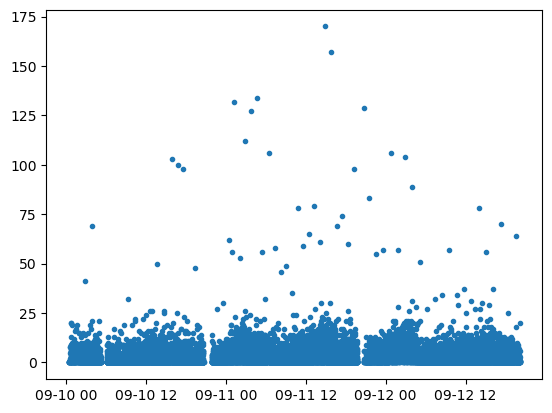

In [18]:
plt.plot(binned['rep_timestamp'], binned['Pseudo-nitzschia'],'.')

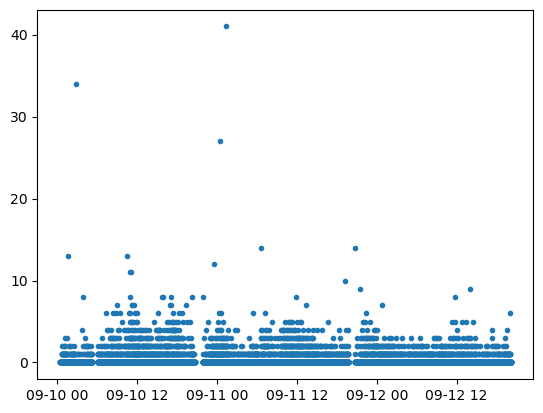

In [19]:
plt.plot(binned['rep_timestamp'], binned['Akashiwo'],'.')
#plt.scatter(binned['rep_timestamp'], binned['depth_bin_center'], c=binned['Pseudo-nitzschia'],s=3)

  depth bin: 2.5  to  7.5  number of points: 1
mean species: nan  mean time: 1.757377842e+18
  depth bin: 7.5  to  12.5  number of points: 1
mean species: nan  mean time: 1.757377886e+18
  depth bin: 12.5  to  17.5  number of points: 1
mean species: nan  mean time: 1.757377912e+18
  depth bin: 17.5  to  22.5  number of points: 0
  depth bin: 22.5  to  27.5  number of points: 0
  depth bin: 27.5  to  32.5  number of points: 0
  depth bin: 32.5  to  37.5  number of points: 0
  depth bin: 37.5  to  42.5  number of points: 0
  depth bin: 2.5  to  7.5  number of points: 1
mean species: nan  mean time: 1.75737899e+18
  depth bin: 7.5  to  12.5  number of points: 1
mean species: nan  mean time: 1.757379036e+18
  depth bin: 12.5  to  17.5  number of points: 1
mean species: nan  mean time: 1.75737907e+18
  depth bin: 17.5  to  22.5  number of points: 1
mean species: nan  mean time: 1.7573791e+18
  depth bin: 22.5  to  27.5  number of points: 1
mean species: nan  mean time: 1.757379126e+18
  dep

C:\Users\flbahr\AppData\Local\Temp\ipykernel_67740\754067738.py:48: RuntimeWarning: Mean of empty slice
  nsp[j,i]=np.nanmean(sp[ind])
C:\Users\flbahr\AppData\Local\Temp\ipykernel_67740\754067738.py:63: RuntimeWarning: Mean of empty slice
  nsp[j,i]=np.nanmean(sp[ind])


  depth bin: 2.5  to  7.5  number of points: 1
mean species: 2.0  mean time: 1.757527096e+18
  depth bin: 7.5  to  12.5  number of points: 1
mean species: 2.0  mean time: 1.757527112e+18
  depth bin: 12.5  to  17.5  number of points: 1
mean species: 0.0  mean time: 1.757527132e+18
  depth bin: 17.5  to  22.5  number of points: 1
mean species: 0.0  mean time: 1.757527156e+18
  depth bin: 22.5  to  27.5  number of points: 1
mean species: 0.0  mean time: 1.757527174e+18
  depth bin: 27.5  to  32.5  number of points: 1
mean species: 0.0  mean time: 1.757527192e+18
  depth bin: 32.5  to  37.5  number of points: 1
mean species: 0.0  mean time: 1.757527206e+18
  depth bin: 37.5  to  42.5  number of points: 0
  depth bin: 2.5  to  7.5  number of points: 1
mean species: 0.0  mean time: 1.757527316e+18
  depth bin: 7.5  to  12.5  number of points: 1
mean species: 1.0  mean time: 1.757527334e+18
  depth bin: 12.5  to  17.5  number of points: 1
mean species: 0.0  mean time: 1.757527354e+18
  depth

C:\Users\flbahr\AppData\Local\Temp\ipykernel_67740\754067738.py:80: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot=ax.pcolor(time_masked,-ndp,nsp,cmap='YlGn',vmin=0,vmax=10)
C:\Users\flbahr\AppData\Local\Temp\ipykernel_67740\754067738.py:97: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(plot,ax=ax)


  depth bin: 2.5  to  7.5  number of points: 1
mean species: nan  mean time: 1.757377842e+18
  depth bin: 7.5  to  12.5  number of points: 1
mean species: nan  mean time: 1.757377886e+18
  depth bin: 12.5  to  17.5  number of points: 1
mean species: nan  mean time: 1.757377912e+18
  depth bin: 17.5  to  22.5  number of points: 0
  depth bin: 22.5  to  27.5  number of points: 0
  depth bin: 27.5  to  32.5  number of points: 0
  depth bin: 32.5  to  37.5  number of points: 0
  depth bin: 37.5  to  42.5  number of points: 0
  depth bin: 2.5  to  7.5  number of points: 1
mean species: nan  mean time: 1.75737899e+18
  depth bin: 7.5  to  12.5  number of points: 1
mean species: nan  mean time: 1.757379036e+18
  depth bin: 12.5  to  17.5  number of points: 1
mean species: nan  mean time: 1.75737907e+18
  depth bin: 17.5  to  22.5  number of points: 1
mean species: nan  mean time: 1.7573791e+18
  depth bin: 22.5  to  27.5  number of points: 1
mean species: nan  mean time: 1.757379126e+18
  dep

C:\Users\flbahr\AppData\Local\Temp\ipykernel_67740\754067738.py:78: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot=ax.pcolor(time_masked,-ndp,nsp,cmap='YlGn',vmin=0,vmax=100)


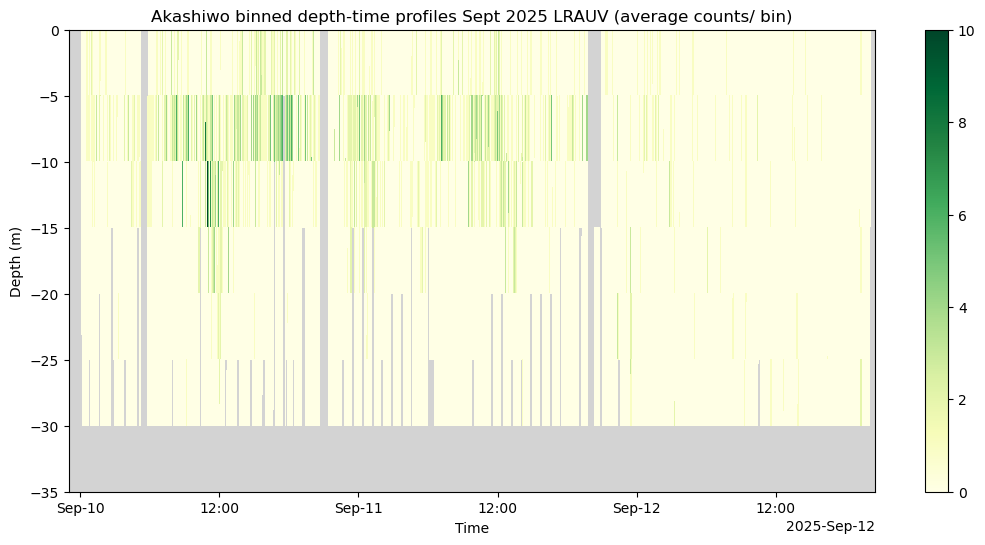

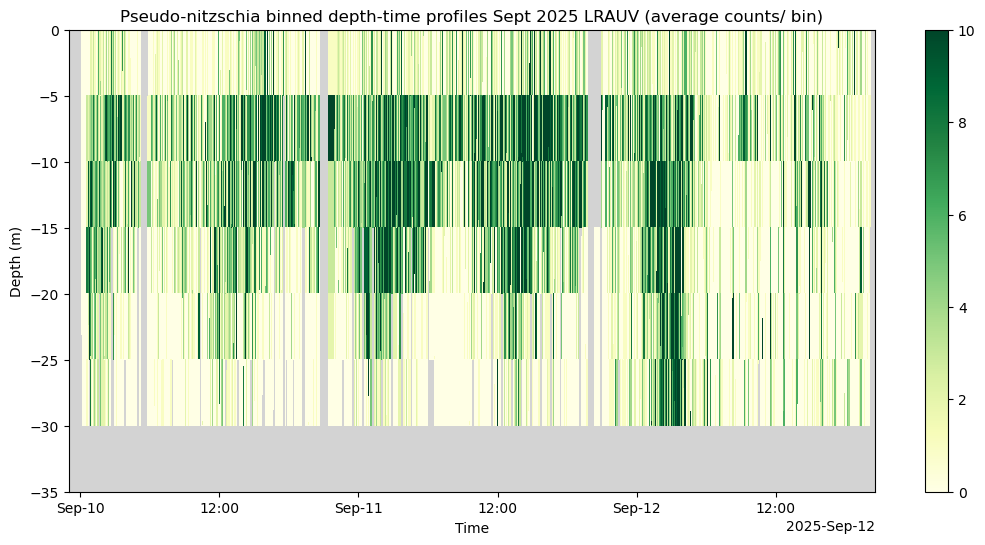

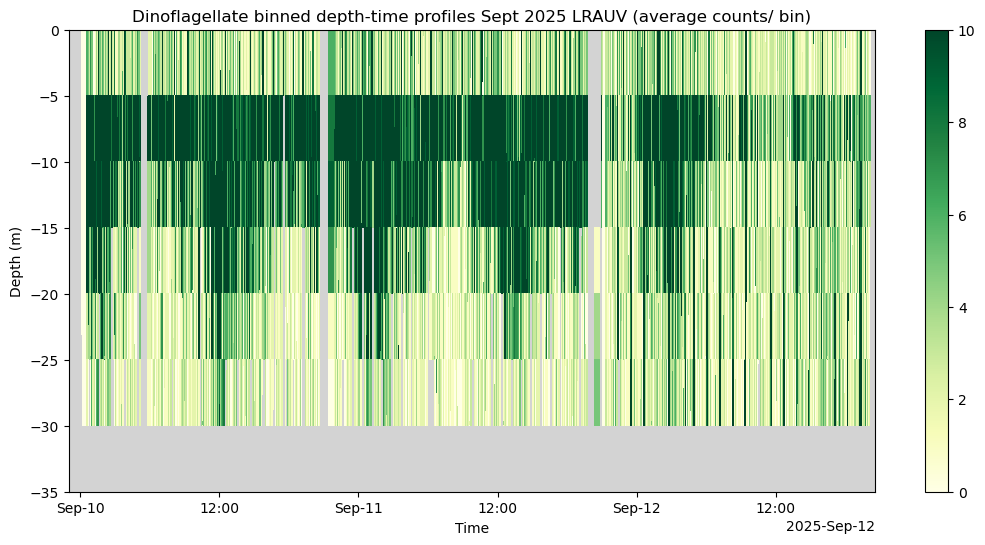

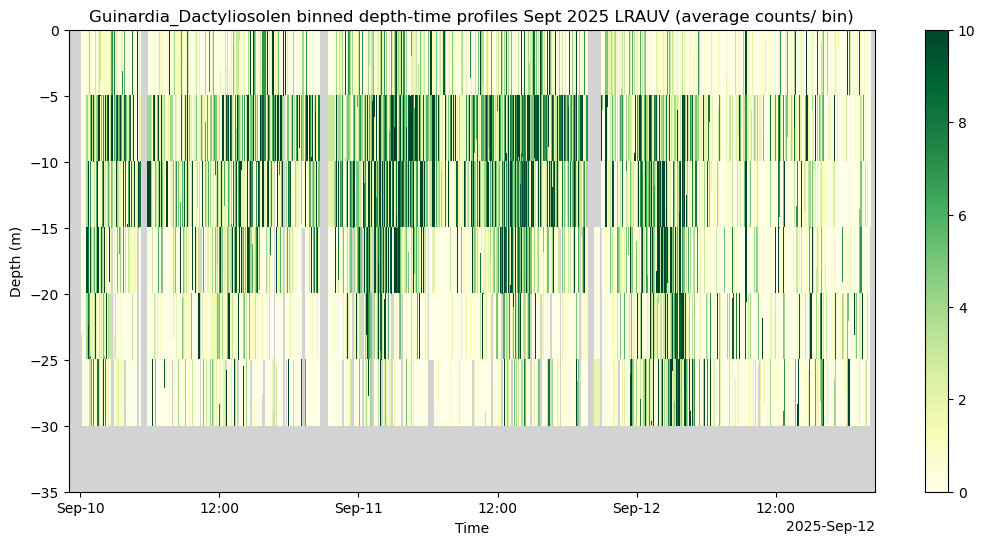

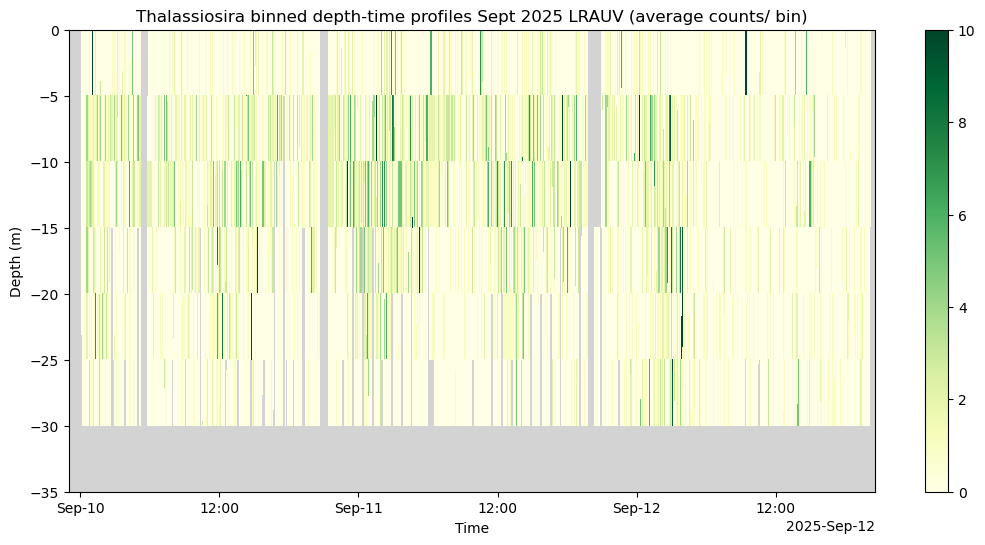

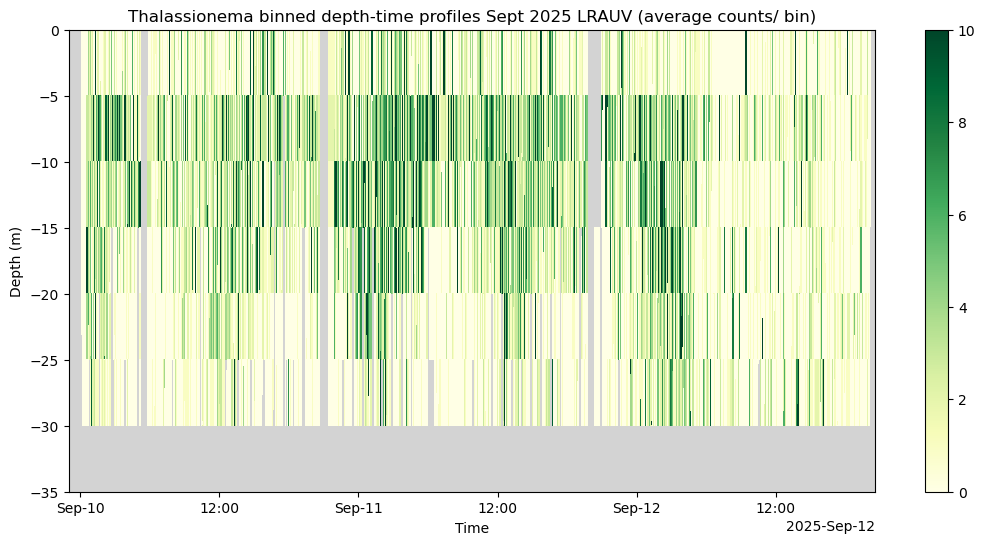

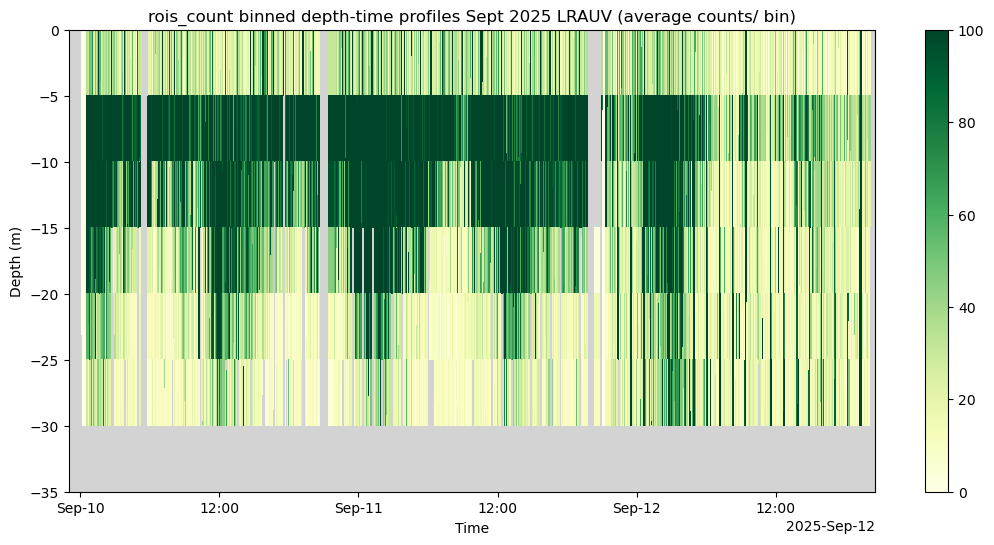

In [22]:
import matplotlib.dates as mdates
import pdb
imagelabel=['Akashiwo','Pseudo-nitzschia','Dinoflagellate','Guinardia_Dactyliosolen','Thalassiosira','Thalassionema','rois_count']
icount=np.arange(0,len(imagelabel))

uid=np.unique(binned['cast_id'])
#lp=np.arange(0,5)
bins_d=binned['depth_bin_center'].values
lp=np.arange(0,len(uid))
#print(bins_d.max(),bins_d.min())
phase=binned['phase'].values
castid=binned['cast_id'].values
for ii in icount:
    label=imagelabel[ii]
#label='Akashiwo'
#label='Pseudo-nitzschia'
#label='Dinoflagellate'
#label='Guinardia_Dactyliosolen'
#label='Thalassionema'
#label='Thalassiosira'

#label='Detritus'
    species=binned[label].values
    timestamp=binned['rep_timestamp'].values
#distance=binned['rep_timestamp'].values
#distance=binned['distance_km'].values
    dvec=np.arange(2.5,45.5,5)
# number of profiles up and down
    nsp=np.zeros((len(dvec),len(lp)))
    nsp=nsp*np.nan
    ndp=np.zeros((len(dvec),len(lp)))
    ndp=ndp*np.nan
    ndd=np.zeros((len(dvec),len(lp)))
    ndd=ndd*np.nan
    for i in lp:
        index=np.where((castid==uid[i]) & (phase=='down'))
        bd=bins_d[index]
        sp=species[index]
        time=timestamp[index]
    #dist=distance[index]
    #print(bd.shape,sp.shape,dist.shape)
    #print('Processing cast id:', uid[i])
        for j in range(0,len(dvec)-1):
            ndp[j,i]=dvec[j]
            ind=np.where((bd>=dvec[j]) & (bd<dvec[j+1]))
            print('  depth bin:', dvec[j], ' to ', dvec[j+1], ' number of points:', len(ind[0]))
            if len(ind[0])>0:
                nsp[j,i]=np.nanmean(sp[ind])
                mean_time=np.nanmean(time[ind].astype('datetime64[ns]').astype(np.int64))
                ndd[j,i]=mean_time.astype('datetime64[ns]')
            #ndd[j,i]=np.nanmean(dist[ind])
                print('mean species:', nsp[j,i], ' mean time:', ndd[j,i])
        index=np.where((castid==uid[i]) & (phase=='up'))
        bd=bins_d[index]
        sp=species[index]
        time=timestamp[index]
    #dist=distance[index]
        for j in range(0,len(dvec)-1):
            ndp[j,i]=dvec[j]
            ind=np.where((bd>=dvec[j]) & (bd<dvec[j+1]))
        #print('  depth bin:', dvec[j], ' to ', dvec[j+1], ' number of points:', len(ind[0]))
            if len(ind[0])>0:
                nsp[j,i]=np.nanmean(sp[ind])
                mean_time=np.nanmean(time[ind].astype('datetime64[ns]').astype(np.int64))
                ndd[j,i]=mean_time.astype('datetime64[ns]')
            #ndd[j,i]=np.nanmean(dist[ind])
    #pdb.set_trace()
    fig,ax=plt.subplots(figsize=(13,6))
#time_in_days=ndd.astype('datetime64[ns]').astype(np.float64)/864e13
    time_nums=mdates.date2num(ndd.astype('datetime64[ns]'))
    time_masked=np.ma.masked_invalid(time_nums)
#time_masked=np.ma.masked_invalid(time_in_days)
#time_to_plot=pd.to_datetime(ndd.flatten()).to_pydatetime()
#time_to_plot=time_to_plot.reshape(ndd.shape)
#plot=ax.scatter(time_masked,-ndp,nsp,vmin=0,vmax=60,cmap='plasma')
    ax.set_facecolor('lightgray')
    if ii==6:
        plot=ax.pcolor(time_masked,-ndp,nsp,cmap='YlGn',vmin=0,vmax=100)
    else:
        plot=ax.pcolor(time_masked,-ndp,nsp,cmap='YlGn',vmin=0,vmax=10)
#plot=ax.pcolor(time_masked,-ndp,nsp,cmap='plasma',vmin=0,vmax=10)
#ax.invert_yaxis()
#ax.set_xlabel('Distance (km)')
    locator=mdates.AutoDateLocator()
    formatter=mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel('Time')
    ax.set_ylabel('Depth (m)')
    xlow=dt.datetime(2025,9,9,23,0)
    ax.set_xlim(xlow, np.max(time_masked))
#date_form=mdates.DateFormatter('%m-%d\n%H:%M')
#ax.xaxis.set_major_formatter(date_form)
#plot.set_array(nsp.flatten())
#ax.xaxis_date()
    ax.set_title(label + ' binned depth-time profiles Sept 2025 LRAUV (average counts/ bin)')
    fig.colorbar(plot,ax=ax)
#fig.autofmt_xdate()
#plt.tight_layout()
#plt.savefig(fig_dir / 'Sept2025_PN_binned_depthtime_profiles_updown_perphase_edges.png', dpi=300, bbox_inches='tight')
    outname='Sept2025_' + label + '_binned_depthtime_profiles_updown_perphase_edges_greybackground.png'
    plt.savefig(fig_dir /outname, dpi=300, bbox_inches='tight')


In [ ]:

plt.pcolor(ndd,ndp,nsp)

In [ ]:
import matplotlib.dates as mdates
fig,ax=plt.subplots(figsize=(13,6))
#time_in_days=ndd.astype('datetime64[ns]').astype(np.float64)/864e13
time_nums=mdates.date2num(ndd.astype('datetime64[ns]'))
time_masked=np.ma.masked_invalid(time_nums)
#time_masked=np.ma.masked_invalid(time_in_days)
#time_to_plot=pd.to_datetime(ndd.flatten()).to_pydatetime()
#time_to_plot=time_to_plot.reshape(ndd.shape)
#plot=ax.scatter(time_masked,-ndp,nsp,vmin=0,vmax=60,cmap='plasma')
plot=ax.pcolor(time_masked,-ndp,nsp,cmap='YlGn',vmin=0,vmax=10)
#plot=ax.pcolor(time_masked,-ndp,nsp,cmap='plasma',vmin=0,vmax=10)
#ax.invert_yaxis()
#ax.set_xlabel('Distance (km)')
locator=mdates.AutoDateLocator()
formatter=mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time')
ax.set_ylabel('Depth (m)')
xlow=dt.datetime(2025,9,9,23,0)
ax.set_xlim(xlow, np.max(time_masked))
#date_form=mdates.DateFormatter('%m-%d\n%H:%M')
#ax.xaxis.set_major_formatter(date_form)
#plot.set_array(nsp.flatten())
#ax.xaxis_date()
ax.set_title(label + ' binned depth-time profiles Sept 2025 LRAUV (average counts/ bin)')
fig.colorbar(plot,ax=ax)
#fig.autofmt_xdate()
#plt.tight_layout()
#plt.savefig(fig_dir / 'Sept2025_PN_binned_depthtime_profiles_updown_perphase_edges.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir / 'Sept2025_Akashiwo_binned_depthtime_profiles_updown_perphase_edges.png', dpi=300, bbox_inches='tight')
#plt.savefig(fig_dir / 'Sept2025_Pseudo-nitzschia_binned_depthtime_profiles_updown_perphase_edges.png', dpi=300, bbox_inches='tight')
#plt.savefig(fig_dir / 'Sept2025_Dinoflagellate_binned_depthtime_profiles_updown_perphase_edges.png', dpi=300, bbox_inches='tight')
#plt.savefig(fig_dir / 'Sept2025_Guinardia_Dactyliosolen_binned_depthtime_profiles_updown_perphase_edges.png', dpi=300, bbox_inches='tight')
#plt.savefig(fig_dir / 'Sept2025_Thalassionema_binned_depthtime_profiles_updown_perphase_edges.png', dpi=300, bbox_inches='tight')
#plt.savefig(fig_dir / 'Sept2025_Thalassiosira_binned_depthtime_profiles_updown_perphase_edges.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.plot(nsp.flatten(),'.')

In [ ]:
uid=np.unique(binned['cast_id'])
#lp=np.arange(0,5)
bins_d=binned['depth_bin_center'].values
lp=np.arange(0,len(uid))
#print(bins_d.max(),bins_d.min())
phase=binned['phase'].values
castid=binned['cast_id'].values
#label='Pseudo-nitzschia'
label='Detritus'
species=binned[label].values
distance=binned['distance_km'].values
dvec=np.arange(2.5,203.5,5)
# number of profiles up and down
nsp=np.zeros((len(dvec),len(2*lp)))
nsp=nsp*np.nan
ndp=np.zeros((len(dvec),len(lp)))
ndp=ndp*np.nan
ndd=np.zeros((len(dvec),len(lp)))
ndd=ndd*np.nan
for i in lp:
    index=np.where((castid==uid[i]) & (phase=='down'))
    bd=bins_d[index]
    sp=species[index]
    dist=distance[index]
    for j in range(0,len(dvec)-1):
        ndp[j,i]=dvec[j]
        ind=np.where((bd>=dvec[j]) & (bd<dvec[j+1]))
        if len(ind[0])>0:
            nsp[j,i]=np.nanmean(sp[ind])
            ndd[j,i]=np.nanmean(dist[ind])
    index=np.where((castid==uid[i]) & (phase=='up'))
    bd=bins_d[index]
    sp=species[index]
    dist=distance[index]
    for j in range(0,len(dvec)-1):
        ndp[j,i]=dvec[j]
        ind=np.where((bd>=dvec[j]) & (bd<dvec[j+1]))
        if len(ind[0])>0:
            nsp[j,i]=np.nanmean(sp[ind])
            ndd[j,i]=np.nanmean(dist[ind])

In [ ]:
#print(ndd.shape)
#print(ndp.shape)
#print(nsp.shape)
plot=ax.contourf(ndd,ndp,nsp,cmap='plasma')

In [ ]:
plt.show()

In [ ]:
fig,ax=plt.subplots()
plot=ax.pcolor(ndd,-ndp,nsp,cmap='plasma',vmin=0,vmax=4)
#ax.invert_yaxis()
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (m)')
#plot.set_array(nsp.flatten())
fig.colorbar(plot,ax=ax)
#plt.tight_layout() 



In [ ]:
from matplotlib import dates as mdates
from scipy.interpolate import griddata

# --- 0) Your input long-form data ---
# binned columns needed: start_time (datetime-like), depth (m), sigma_theta (kg/m^3)
binned_df = binned.dropna(subset=["start_time", "depth_bin_center", "sigma_theta"]).copy()
binned_df["start_time"] = pd.to_datetime(binned_df["start_time"])

# --- 1) Build a regular target grid (you pick the resolution) ---
# time grid: from min to max with, e.g., 2-minute spacing (adjust as needed)
tmin, tmax = binned_df["start_time"].min(), binned_df["start_time"].max()
time_grid = pd.date_range(tmin, tmax, freq="60min")  # change interval as appropriate

# depth grid: e.g., 0.5 m spacing from shallowest to deepest observed
zmin, zmax = binned_df["depth_bin_center"].min(), binned_df["depth_bin_center"].max()
depth_grid = np.arange(np.floor(zmin), np.ceil(zmax) + 1, 10)

# Convert times to Matplotlib date numbers (floats) for contouring
t_num = mdates.date2num(binned_df["start_time"].to_numpy())
Tg_num = mdates.date2num(time_grid.to_pydatetime())


# --- 2) Interpolate onto the grid ---
# Prepare source points and values
points = np.column_stack([t_num, binned_df["depth_bin_center"].to_numpy()])
values = binned_df["sigma_theta"].to_numpy()

# Target mesh
TTg, ZZg = np.meshgrid(Tg_num, depth_grid)

# Interpolate; 'linear' is typical; fall back to 'nearest' for gaps
SS = griddata(points, values, (TTg, ZZg), method="linear")
# SS   = griddata(points, values, (TTg, ZZg), method="nearest")

# Fill holes left by linear interpolation with nearest-neighbor
# SS = np.where(np.isnan(SS_linear), SS_near, SS_linear)

# Optional: mask impossible ranges or leave NaN to avoid misleading contours
# SS[(SS < 10) | (SS > 40)] = np.nan  # example sanity check

# --- 3) Choose contour levels ---
# You can pick a fixed range or use percentiles to adapt to each dataset
valid = SS[np.isfinite(SS)]
vmin, vmax = np.percentile(valid, [5, 95]) if valid.size else (24, 27)
levels = np.arange(np.floor(vmin*10)/10, np.ceil(vmax*10)/10 + 1e-9, 0.2)  # every 0.2 kg/m^3
levels = [25.8,26,26.2]

# --- 4) Plot: base scatter (optional) + isopycnal contours ---
fig, ax = plt.subplots(figsize=(12, 6))

# # (Optional) show original points
sc = ax.scatter(binned_df["start_time"], binned_df["depth_bin_center"], c=binned_df["Pseudo-nitzschia"], s=10, cmap="viridis",vmin=0,vmax=2)
plt.colorbar(sc, ax=ax, label="Normalized Image Count")

# Contours (isopycnals) from gridded field
CS = ax.contour(mdates.num2date(TTg), ZZg, SS, levels=levels, colors="w", linewidths=2)
ax.clabel(CS, inline=True, fontsize=8, fmt="%.1f")  # label lines

# Format axes
ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()